In [83]:
import logging
import os
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import wfdb

Annotation reading

Text(0, 0.5, 'V1')

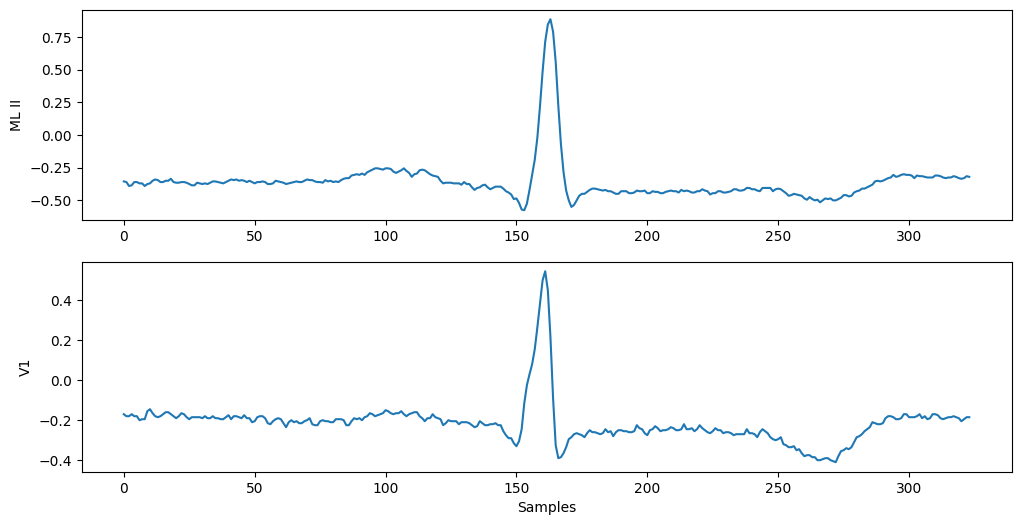

In [84]:
dbdir = 'mit-bih-arrhythmia-database-1.0.0'

if not os.path.isdir(dbdir):
    logging.error('Please replace dbdir with the db direcotry')
    raise FileNotFoundError(dbdir)

symbol_durations = []
avg_symbol_duration = 0
slices = []

for _ in range(100, 220):
    try:
        record = wfdb.rdrecord('{}/{}'.format(dbdir, _))
        annotation = wfdb.rdann('{}/{}'.format(dbdir, _), 'atr')
    except FileNotFoundError:
        continue
    
    fs = annotation.fs
    # annotation.symbol contains annotations (N for normal, V for ventricular etc..., see doc
    # annotation.sample contains the samples of annotations
    timestamp_symbol_tuples = [(i / fs, s) for i, s in zip(annotation.sample[:20], annotation.symbol[:20])]
    
    # 9s (3240 samples) around each symbol
    slice_padding = int(0.9 * fs / 2)
    for t, s in timestamp_symbol_tuples:
        symbol_index = int(t * fs)
        slices.append((s, record.p_signal[(symbol_index - slice_padding if symbol_index > slice_padding else symbol_index - 0):(symbol_index + slice_padding)]))
    
    # print('Record {}: {}samples (={:.3f}s)'.format(_, record.p_signal.shape, len(record.p_signal) / fs))
    # print(' '.join('{:3.1f}:{}'.format(i, s) for i, s in timestamp_symbol_tuples))
    symbol_durations.extend([(timestamp_symbol_tuples[j][0] - timestamp_symbol_tuples[j - 1][0]) for j in range(1, len(timestamp_symbol_tuples))])

# plt.hist(symbol_durations)
#plt.title('Distribution of Symbol Durations')
#plt.xlabel('Duration')
#plt.ylabel('Frequency')
# plt.show()

# Based on this I propose slices to be 0.9s long to capture all the needed information
# print('Average duration: {}'.format(round(np.average(symbol_durations), 3)))
# print('Median duration: {}'.format(round(np.median(symbol_durations), 3)))
# print('Standard deviation of duration: {}'.format(round(np.std(symbol_durations), 3)))

fig, ax = plt.subplots(nrows=2, figsize=(12, 6))
MLII = slices[9][1][:, 0]
V1 = slices[9][1][:, 1]

ax[0].plot(MLII)
ax[1].plot(V1)
ax[0].set_ylabel('ML II')
ax[1].set_xlabel('Samples')
ax[1].set_ylabel('V1')

# Distribution of classes

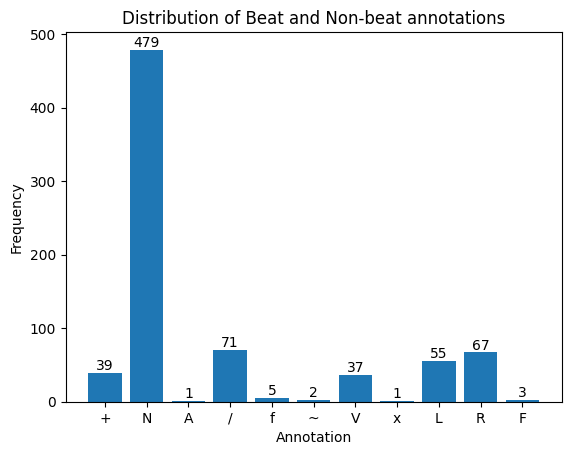

In [87]:
labels, values = zip(*Counter([s[0] for s in slices]).items())
plt.bar(labels, values)
for i, v in enumerate(values):
        plt.text(i, v + 0.1, str(v), ha='center', va='bottom')
plt.title('Distribution of Beat and Non-beat annotations')
plt.xlabel('Annotation')
plt.ylabel('Frequency')
plt.show()

## Beat annotations
(\+)      Rhythm change

(N)       Normal beat

(A)		Atrial premature beat

(/)		Paced beat

(f)		Fusion of paced and normal beat

(~)		Change in signal quality

(V)		Premature ventricular contraction

(x)		Non-conducted P-wave (blocked APC)

(L)		Left bundle branch block beat

(R)		Right bundle branch block beat

(F)		Fusion of ventricular and normal beat